# STX ML
To install:
```
mkvirtualenv venv-ml
workon venv-ml
pip install -r requirements_new.txt
```
Based on code from https://github.com/Kulbear/stock-prediction

In [13]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import stxcal 
from stxts import StxTS 

## Import data
Start with one stock: MSFT; adjust for splits

In [46]:
stk = 'MSFT'
sd = '1960-01-01'
ed = stxcal.current_date()
ts = StxTS(stk, sd, ed)
dt = str(ts.df.index[ts.l - 1].date())
ts.set_day(dt)

8244

In [47]:
ts.df['open_interest'] = ts.df['c'] * ts.df['volume']
ts.df = ts.df[['o', 'hi', 'lo', 'volume', 'open_interest', 'c']]
ts.df.head()

,o,hi,lo,volume,open_interest,c
1986-03-13,0.079994,0.089993,0.079994,1.151131e+06,97190.94,0.084431
1986-03-14,0.084431,0.089993,0.084431,3.446672e+05,31017.60,0.089993
1986-03-17,0.089993,0.095555,0.089993,1.488118e+05,13392.00,0.089993
1986-03-18,0.089993,0.095555,0.089993,7.424587e+04,6681.60,0.089993
1986-03-19,0.089993,0.089993,0.084431,5.376425e+04,4838.40,0.089993


Normalize the data prior to feeding into model

In [48]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    return X_train, X_test, preprocessor

Split the data intoX_train, y_train, X_test, y_test

In [49]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
    result = np.array(result)
    row = round(0.95 * result.shape[0])
    train = result[: int(row), :]
    
    train, result, preprocessor = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test, preprocessor]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Connected(Dense)

In [50]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.35))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [51]:
window = 200
X_train, y_train, X_test, y_test, preprocessor = preprocess_data(ts.df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (7642, 200, 6))
('y_train', (7642,))
('X_test', (402, 200, 6))
('y_test', (402,))


In [54]:
model = build_model([X_train.shape[2], window, 700, 1])

/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=200, return_sequences=True, input_shape=(None, 6))`
  


('Compilation Time : ', 0.03517889976501465)


/home/cma/.envs/venv-ml/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


## Training the Network

In [55]:
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=50,
    validation_split=0.1,
    verbose=1)

Train on 6877 samples, validate on 765 samples
Epoch 1/50
6877/6877 [==============================] - 398s 58ms/step - loss: 5.0405 - acc: 0.0000e+00 - val_loss: 0.7948 - val_acc: 0.0000e+00
Epoch 2/50
6877/6877 [==============================] - 391s 57ms/step - loss: 0.0233 - acc: 0.0000e+00 - val_loss: 0.2436 - val_acc: 0.0000e+00
Epoch 3/50
6877/6877 [==============================] - 386s 56ms/step - loss: 0.0134 - acc: 0.0000e+00 - val_loss: 0.1801 - val_acc: 0.0000e+00
Epoch 4/50
6877/6877 [==============================] - 386s 56ms/step - loss: 0.0263 - acc: 0.0000e+00 - val_loss: 0.0330 - val_acc: 0.0000e+00
Epoch 5/50
6877/6877 [==============================] - 385s 56ms/step - loss: 0.0228 - acc: 0.0000e+00 - val_loss: 0.2334 - val_acc: 0.0000e+00
Epoch 6/50
6877/6877 [==============================] - 385s 56ms/step - loss: 0.0309 - acc: 0.0000e+00 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 7/50
6877/6877 [==============================] - 385s 56ms/step - loss: 0.02

In [56]:
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

7642/7642 [==============================] - 231s 30ms/step
Train Score: 0.00 MSE (0.04 RMSE)
402/402 [==============================] - 12s 30ms/step
Test Score: 0.18 MSE (0.42 RMSE)


In [57]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [58]:
# TODO: Scale it back

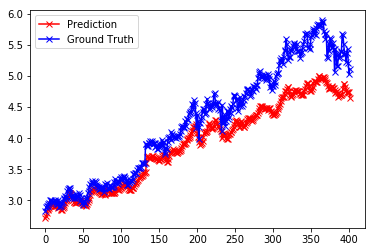

In [59]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', marker='x', label='Prediction')
plt2.plot(y_test, color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

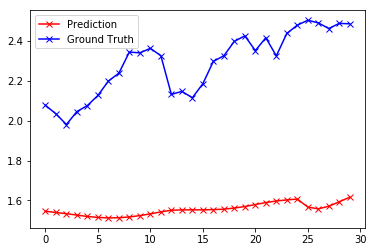

In [36]:
plt2.plot(pred[0:30], color='red', marker='x', label='Prediction')
plt2.plot(y_test[0:30], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

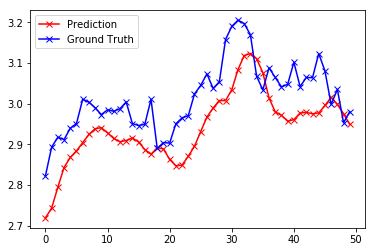

In [60]:
plt2.plot(pred[:50], color='red', marker='x', label='Prediction')
plt2.plot(y_test[:50], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

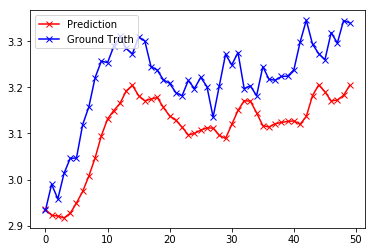

In [61]:
plt2.plot(pred[50:100], color='red', marker='x', label='Prediction')
plt2.plot(y_test[50:100], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

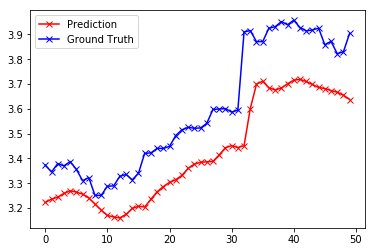

In [62]:
plt2.plot(pred[100:150], color='red', marker='x', label='Prediction')
plt2.plot(y_test[100:150], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

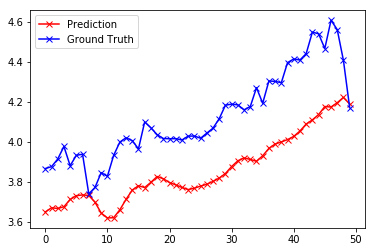

In [63]:
plt2.plot(pred[150:200], color='red', marker='x', label='Prediction')
plt2.plot(y_test[150:200], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

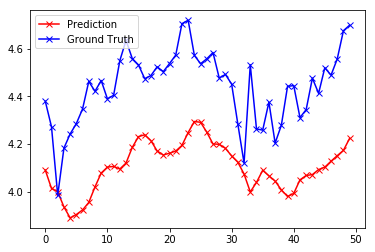

In [64]:
plt2.plot(pred[200:250], color='red', marker='x', label='Prediction')
plt2.plot(y_test[200:250], color='blue', marker='x', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()